In [ ]:
# === 1. Завантаження ukr-eng.zip через wget ======================
import os, zipfile, pandas as pd

url = "https://www.manythings.org/anki/ukr-eng.zip"
zip_path = "/content/ukr-eng.zip"
extract_path = "/content/ukr_eng"

print("⬇️ Завантаження датасету...")
os.system(f"wget -q {url} -O {zip_path}")

# === 2. Розпакування ============================================
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_path)
print("✅ Розпаковано!")

# === 3. Читання та очищення =====================================
file_path = os.path.join(extract_path, "ukr.txt")

data = []
with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) >= 2:  # беремо тільки перші два поля
            eng, ukr = parts[0], parts[1]
            data.append((ukr, eng))  # українська → англійська

# === 4. Створення DataFrame =====================================
df = pd.DataFrame(data, columns=["ukrainian", "english"])
print(f"Загальна кількість пар у повному наборі: {len(df):,}")

# === 5. Створюємо меншу підмножину ==============================
df_small = df.sample(n=20000, random_state=42).reset_index(drop=True)
print(f"✅ Розмір підмножини: {df_small.shape}")

print("\nПерші 10 прикладів:")
print(df_small.head(10))

# === 6. Збереження підмножини ===================================
output_path = "/content/ukr_eng_small.csv"
df_small.to_csv(output_path, index=False)
print(f"\n✅ Збережено: {output_path}")


⬇️ Завантаження датасету...
✅ Розпаковано!
Загальна кількість пар у повному наборі: 160,049
✅ Розмір підмножини: (20000, 2)

Перші 10 прикладів:
                             ukrainian  \
0       Можливо, все пройде нормально.   
1     Вам потрібно вивчити французьку.   
2       Том дожив до дев'яноста років.   
3        Вибачте мене за незграбність.   
4  Тигреня виглядало як велике кошеня.   
5                Це насправді спрацює?   
6                 Ми живемо в будинку.   
7          Зробити це було ідеєю Тома.   
8                 Вам все це потрібно?   
9                   Це потужний лазер.   

                                     english  
0          Maybe everything'll go all right.  
1                  You need to learn French.  
2                    Tom lived to be ninety.  
3                      Excuse my clumsiness.  
4  The tiger cub looked like a large kitten.  
5                     Will that really work?  
6                        We live in a house.  
7              I

In [ ]:
# === 7. Попередня обробка текстів ===============================
import re
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter

# Функція очищення речень
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zа-яіїєґ’'\s]", "", text)
    return re.sub(r"\s+", " ", text).strip()

df_small["ukrainian_clean"] = df_small["ukrainian"].apply(clean_text)
df_small["english_clean"] = df_small["english"].apply(clean_text)

# Додаємо токени початку і кінця речення для українських фраз
df_small["ukrainian_clean"] = df_small["ukrainian_clean"].apply(lambda x: f"<sos> {x} <eos>")

print("🔤 Приклад очищених пар:")
print(df_small[["ukrainian_clean", "english_clean"]].head(5))

# === 8. Токенізація та словники ==========================
def build_vocab(sentences, max_size=10000):
    counter = Counter()
    for s in sentences:
        counter.update(s.split())
    vocab = ["<pad>", "<unk>"] + [w for w, _ in counter.most_common(max_size - 2)]
    stoi = {w: i for i, w in enumerate(vocab)}
    itos = {i: w for w, i in stoi.items()}
    return stoi, itos

ukr_stoi, ukr_itos = build_vocab(df_small["ukrainian_clean"])
eng_stoi, eng_itos = build_vocab(df_small["english_clean"])

print(f"🔠 Розмір словника (укр): {len(ukr_stoi)}")
print(f"🔠 Розмір словника (англ): {len(eng_stoi)}")

# === 9. Кодування речень у тензори ======================
MAX_LEN = 15

def encode_sentence(sentence, stoi):
    tokens = sentence.split()
    ids = [stoi.get(t, stoi["<unk>"]) for t in tokens]
    ids = ids[:MAX_LEN] + [stoi["<pad>"]] * (MAX_LEN - len(ids))
    return torch.tensor(ids, dtype=torch.long)

df_small["ukr_encoded"] = df_small["ukrainian_clean"].apply(lambda x: encode_sentence(x, ukr_stoi))
df_small["eng_encoded"] = df_small["english_clean"].apply(lambda x: encode_sentence(x, eng_stoi))

# === 10. Dataset і DataLoader ===========================
class TranslationDataset(Dataset):
    def __init__(self, df):
        self.src = list(df["ukr_encoded"])
        self.trg = list(df["eng_encoded"])
    def __len__(self):
        return len(self.src)
    def __getitem__(self, idx):
        return self.src[idx], self.trg[idx]

dataset = TranslationDataset(df_small)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

print(f"✅ Дані готові до навчання: {len(train_ds)} train / {len(test_ds)} test")


🔤 Приклад очищених пар:
                                  ukrainian_clean  \
0        <sos> можливо все пройде нормально <eos>   
1     <sos> вам потрібно вивчити французьку <eos>   
2       <sos> том дожив до дев'яноста років <eos>   
3        <sos> вибачте мене за незграбність <eos>   
4  <sos> тигреня виглядало як велике кошеня <eos>   

                              english_clean  
0          maybe everything'll go all right  
1                  you need to learn french  
2                    tom lived to be ninety  
3                      excuse my clumsiness  
4  the tiger cub looked like a large kitten  
🔠 Розмір словника (укр): 10000
🔠 Розмір словника (англ): 5122
✅ Дані готові до навчання: 16000 train / 4000 test


Epoch 1/10: 100%|██████████| 250/250 [07:01<00:00,  1.69s/it]


Epoch [1/10] | Train Loss: 5.6779 | Val Loss: 5.1297


Epoch 2/10: 100%|██████████| 250/250 [07:00<00:00,  1.68s/it]


Epoch [2/10] | Train Loss: 4.1568 | Val Loss: 4.3686


Epoch 3/10: 100%|██████████| 250/250 [07:01<00:00,  1.69s/it]


Epoch [3/10] | Train Loss: 2.9653 | Val Loss: 4.0302


Epoch 4/10: 100%|██████████| 250/250 [06:59<00:00,  1.68s/it]


Epoch [4/10] | Train Loss: 2.0264 | Val Loss: 3.9015


Epoch 5/10: 100%|██████████| 250/250 [06:58<00:00,  1.67s/it]


Epoch [5/10] | Train Loss: 1.4082 | Val Loss: 3.8911


Epoch 6/10: 100%|██████████| 250/250 [07:04<00:00,  1.70s/it]


Epoch [6/10] | Train Loss: 0.9968 | Val Loss: 3.9560


Epoch 7/10: 100%|██████████| 250/250 [07:02<00:00,  1.69s/it]


Epoch [7/10] | Train Loss: 0.6805 | Val Loss: 4.0371


Epoch 8/10: 100%|██████████| 250/250 [07:00<00:00,  1.68s/it]


Epoch [8/10] | Train Loss: 0.4767 | Val Loss: 4.1351


Epoch 9/10: 100%|██████████| 250/250 [07:01<00:00,  1.69s/it]


Epoch [9/10] | Train Loss: 0.3262 | Val Loss: 4.2481


Epoch 10/10: 100%|██████████| 250/250 [07:00<00:00,  1.68s/it]


Epoch [10/10] | Train Loss: 0.2433 | Val Loss: 4.3167
✅ Навчання завершено!


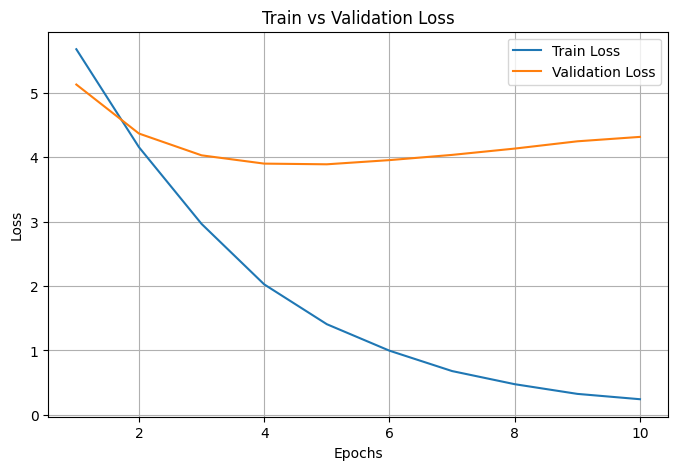

Word-level Test Accuracy: 30.37%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 1️⃣ Encoder =====================================================
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=False)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, (hidden, cell)

# === 2️⃣ Attention ===================================================
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

    def forward(self, hidden, encoder_outputs):
        # hidden: [num_layers, batch, hidden_dim] -> беремо останній шар
        hidden_last = hidden[-1].unsqueeze(2)  # [batch, hidden_dim, 1]
        # encoder_outputs: [batch, seq_len, hidden_dim]
        energy = torch.bmm(encoder_outputs, hidden_last).squeeze(2)  # [batch, seq_len]
        attn_weights = torch.softmax(energy, dim=1)  # [batch, seq_len]
        return attn_weights

# === 3️⃣ Decoder з Attention =========================================
class DecoderAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim + hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.attention = Attention(hidden_dim)

    def forward(self, x, hidden, cell, encoder_outputs):
        x = x.unsqueeze(1)  # [batch, 1]
        embedded = self.embedding(x)  # [batch, 1, emb_dim]

        # обчислюємо attention
        attn_weights = self.attention(hidden, encoder_outputs)  # [batch, seq_len]
        attn_weights = attn_weights.unsqueeze(1)  # [batch, 1, seq_len]

        # контекстний вектор
        context = torch.bmm(attn_weights, encoder_outputs)  # [batch, 1, hidden_dim]

        # LSTM отримує ембединг + context
        lstm_input = torch.cat([embedded, context], dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

        # прогноз
        output = torch.cat([output.squeeze(1), context.squeeze(1)], dim=1)
        prediction = self.fc_out(output)
        return prediction, hidden, cell

# === 4️⃣ Seq2Seq з Attention ========================================
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        encoder_outputs, (hidden, cell) = self.encoder(src)

        input = trg[:, 0]  # <sos>

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs

# === 5️⃣ Ініціалізація моделі ========================================
INPUT_DIM = len(ukr_stoi)
OUTPUT_DIM = len(eng_stoi)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HIDDEN_DIM = 512

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HIDDEN_DIM).to(device)
decoder = DecoderAttention(OUTPUT_DIM, DEC_EMB_DIM, HIDDEN_DIM).to(device)
model = Seq2SeqAttention(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=ukr_stoi["<pad>"])

# === 6️⃣ Навчання ====================================================
EPOCHS = 10
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    model.train()
    for src, trg in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        output = model(src, trg)
        output_dim = output.shape[-1]

        output = output[:, 1:].reshape(-1, output_dim)
        trg_flat = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg_flat)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    # Валідаційна втрата
    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, teacher_forcing_ratio=0)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg_flat = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg_flat)
            val_epoch_loss += loss.item()
    avg_val_loss = val_epoch_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_epoch_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print("✅ Навчання завершено!")

# === 7️⃣ Побудова графіків ==========================================
def plot_metrics(train_losses, val_losses):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(train_losses, val_losses)

# === 8️⃣ Тестування моделі ========================================
def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, teacher_forcing_ratio=0)
            pred_ids = output.argmax(dim=2)  # [batch, seq_len]
            all_preds.extend(pred_ids.cpu().numpy().flatten())
            all_labels.extend(trg.cpu().numpy().flatten())

    # ігноруємо <pad>
    mask = [i for i, lbl in enumerate(all_labels) if lbl != ukr_stoi["<pad>"]]
    filtered_preds = [all_preds[i] for i in mask]
    filtered_labels = [all_labels[i] for i in mask]

    acc = accuracy_score(filtered_labels, filtered_preds) * 100
    print(f"Word-level Test Accuracy: {acc:.2f}%")
    return acc

test_acc = test_model(model, test_loader, device)


In [ ]:
# === 17. Приклад перекладу 10 речень з тесту ===================
model.eval()

# Візьмемо перші 10 речень з test_loader
examples = []
true_texts = []

for src, trg in test_loader:
    for s, t in zip(src, trg):
        examples.append(s)
        true_texts.append(t)
    if len(examples) >= 10:
        break

examples = examples[:10]
true_texts = true_texts[:10]

with torch.no_grad():
    for i, src_tensor in enumerate(examples):
        src_tensor = src_tensor.unsqueeze(0).to(device)  # додаємо batch_size=1
        trg_tensor = torch.zeros_like(true_texts[i]).unsqueeze(0).to(device)

        output = model(src_tensor, trg_tensor, teacher_forcing_ratio=0)  # без teacher forcing
        predicted_ids = output.argmax(dim=2).squeeze(0)  # [seq_len]

        # Перетворюємо назад у слова
        src_words = [ukr_itos[idx.item()] for idx in src_tensor.squeeze(0) if idx.item() != ukr_stoi["<pad>"]]
        trg_words = [eng_itos[idx.item()] for idx in true_texts[i] if idx.item() != eng_stoi["<pad>"]]
        pred_words = [eng_itos[idx.item()] for idx in predicted_ids if idx.item() != eng_stoi["<pad>"]]

        print(f"UKR: {' '.join(src_words)}")
        print(f"True EN: {' '.join(trg_words)}")
        print(f"Pred EN: {' '.join(pred_words)}\n")


UKR: <sos> у тебе й досі болять ноги <eos>
True EN: do your feet still hurt
Pred EN: still open at you aren't cold at you aren't cold at you do you

UKR: <sos> ця коробка була <unk> <eos>
True EN: the box was too heavy
Pred EN: had to to the school on the school team had to the school team

UKR: <sos> том вірить у <unk> <eos>
True EN: tom believes in magic
Pred EN: believes in the train in the world of the world immigrant of the train

UKR: <sos> ви сміливий <eos>
True EN: you're courageous
Pred EN: you brave the wrong train is dinner of the boss of you did it

UKR: <sos> не треба їй зараз телефонувати <eos>
True EN: don't phone her now
Pred EN: is getting to to her now on me now now to me now now

UKR: <sos> коли побачиш тома передай від мене привіт <eos>
True EN: when you see tom tell him i said hello
Pred EN: how to get tom to get him as old as tom is it to

UKR: <sos> я думав том не виграє <eos>
True EN: i thought tom wouldn't win
Pred EN: tom didn't win to win win didn't do that t